In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import vnn
import torchvision
from imp import reload

In [132]:
#CIFAR

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = torchvision.datasets.CIFAR10("./data", train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10("./data", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [333]:
#MNIST 

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.1307,), (0.3081,))])
train_set = torchvision.datasets.MNIST("./data", train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST("./data", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=200, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=200, shuffle=False)


In [335]:
model = nn.Sequential(nn.Conv2d(3, 96, 5, stride=2),
                      nn.ReLU(),
                      nn.Conv2d(96, 96, 3, stride=2),
                      nn.ReLU(),
                      nn.Conv2d(96, 96, 3, stride=1),
                      nn.ReLU(),
                      nn.Flatten(),
                      nn.Linear(1536, 10)).to(0)
input = torch.randn(1000, 3, 28, 28).to(0)
out = model(input).detach().cpu().numpy().flatten()
plt.hist(out)


RuntimeError: mat1 dim 1 must match mat2 dim 0

In [338]:
reload(vnn)
mono = True
model = nn.Sequential(vnn.Conv2d(10, 30, 96, 5, stride=2, mono=mono, first_layer=True),
                      vnn.tReLU(),
                      vnn.Conv2d(10, 96, 96, 3, stride=2, mono=mono),
                      vnn.tReLU(),
                      vnn.Conv2d(10, 96, 96, 3, stride=1, mono=mono),
                      vnn.tReLU(),
                      vnn.Flatten(),
                      vnn.Linear(10, 1536, 1200, mono=mono),
                      vnn.tReLU(),
                      vnn.Linear(10, 1200, 600, mono=mono),
                      vnn.tReLU(),
                      vnn.Linear(10, 600, 1, mono=mono)).to(0)

data = torch.randn(200, 3, 32, 32)
input = vnn.expand_input_conv(data, 10).to(0)

Instantiated t with shape (10, 96, 14, 14)
Instantiated t with shape (10, 96, 6, 6)
Instantiated t with shape (10, 96, 4, 4)
Instantiated t with shape (10, 1200)
Instantiated t with shape (10, 600)


0.90373886

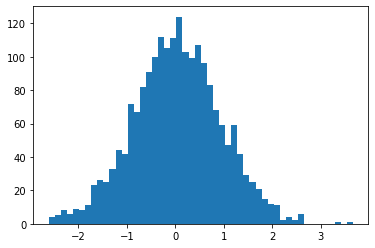

In [339]:
out = model(input)
vals = out.cpu().detach().numpy().flatten()
plt.hist(vals, bins=50)
vals.std()

In [58]:
loss_fn = nn.CrossEntropyLoss(reduction="mean")
opt = optim.Adam(model.parameters(), lr=1e-3)

for epoch_idx in range(1000):
    print(epoch_idx)
    epoch_loss = 0.
    epoch_correct = 0.
    for batch_idx, (data, labels) in enumerate(train_loader):
        input = vnn.expand_input_conv(data, 10).to(0)
        out = model(input)[..., 0]
        loss = loss_fn(out, labels.to(0))
        epoch_loss += loss.item()
        epoch_correct += (out.argmax(dim=1).cpu() == labels).float().sum().item()
        opt.zero_grad()
        loss.backward()
        opt.step()
        for layer in model: layer.post_step_callback()
    print(epoch_loss / (batch_idx + 1))
    print(epoch_correct / 50000.)

0
125.43787154090374
0.20148
1
3.1320126727413946
0.22958
2
2.195834954986182
0.2543
3
2.0719377342087535
0.27176
4


KeyboardInterrupt: 

In [284]:
num_correct = 0
for batch_idx, (data, labels) in enumerate(test_loader):
    input = vnn.expand_input_conv(data, 10).to(0)
    with torch.no_grad():
        out = model.forward(input)[..., 0]
    num_correct += (out.argmax(dim=1).cpu() == labels).int().sum().item()
acc = num_correct / 10000.
acc

0.4464

In [334]:
reload(vnn)
loss_fn = nn.CrossEntropyLoss(reduction="mean")
opt = optim.Adam(model.parameters(), lr=1e-3)

for epoch_idx in range(1000):
    print(epoch_idx)
    epoch_loss = 0.
    epoch_correct = 0.
    for batch_idx, (data, labels) in enumerate(train_loader):
        input = vnn.expand_input_conv(data, 10).to(0)
        with torch.no_grad():
            out = model(input)[..., 0]
        loss = loss_fn(out, labels.to(0))
        epoch_loss += loss.item()
        epoch_correct += (out.argmax(dim=1).cpu() == labels).float().sum().item()
        opt.zero_grad()
        vnn.set_model_grads(model, out, labels.to(0))
        opt.step()
        for layer in model: layer.post_step_callback()
    print(epoch_loss / (batch_idx + 1))
    print(epoch_correct / 60000.)

0


RuntimeError: Given groups=1, weight of size [96, 30, 5, 5], expected input[2000, 10, 28, 28] to have 30 channels, but got 10 channels instead

In [313]:
reload(vnn)

opt = optim.SGD(model.parameters(), lr=1e-3)

data = torch.randn(200, 3, 32, 32)
labels = torch.randint(0, 10, (len(data),))
input = vnn.expand_input_conv(data, 10).to(0)
out = model(input)[..., 0]
loss = loss_fn(out, labels.to(0))

opt.zero_grad()
loss.backward()
G1 = model[0].conv.weight.grad.detach().cpu().numpy().flatten()

opt.zero_grad()
vnn.set_model_grads(model, out.detach(), labels.to(0))
G2 = model[0].conv.weight.grad.detach().cpu().numpy().flatten()

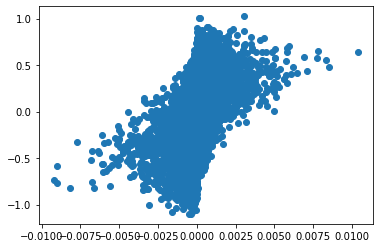

In [314]:
plt.scatter(G1, G2)

In [315]:
np.mean(np.sign(G1) == np.sign(G2))

0.7336111111111111

In [312]:
from scipy.stats import pearsonr
np.rad2deg(np.arccos(pearsonr(G1, G2)))

array([60.46095734, 90.        ])

In [326]:
A = np.random.normal(0, 1, (1000, 1000)) / np.sqrt(1000)
A = np.abs(A)
v = np.linalg.eigvals(A)

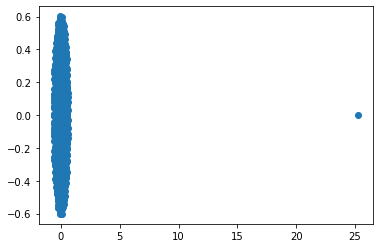

In [328]:
plt.scatter(v.real, v.imag)
#plt.xlim(-1.2, 1.2)
#plt.ylim(-1.2, 1.2)